<a id="introduction"></a>
# The Event-Related Potential

<div class="question">
    
_**Synopsis**_ 

**Data:** 1 s of scalp EEG data sampled at 500 Hz during 1,000 trials in two conditions.

**Goal:** Characterize the response of the EEG in the two conditions.

**Tools:** Visualization, event-related potential, confidence intervals, bootstrapping.
</div>

* [Background](#background)
* [Case Study Data](#case-study-data)
* [Data Analysis](#data-analysis)
    * [Visual Inspection](#visual-inspection)
    * [Plotting the ERP](#plotting-the-erp)
    * [Confidence Intervals for the ERP (Method 1)](#cis-m1)
    * [Comparing ERPs](#comparing-erps)
    * [Confidence Intervals for the ERP (Method 2)](#cis-m2)
    * [A Bootstrap Test to Compare ERPs](#bootstrap)
* [Summary](#summary)

Before we start any computations, let's import some modules and functions that we will use throughout the notebook. A module can be imported any time, but there are a few things that we know we will need straight off the bat. For clarity, it is best practice to import packages at the beginning.

In [1]:
from scipy.io import loadmat       # Import function to read data.
from pylab import *                # Import numerical and plotting functions
from IPython.lib.display import YouTubeVideo  # Enable YouTube videos
# ... make the plots "inline".
%matplotlib inline                 

## On-ramp: computing the event-related potential in Python

We begin this notebook with an "*on-ramp*" to analysis. The purpose of this on-ramp is to introduce you immediately to a core concept in this notebook: how to compute an event-related potential with error bars in Python. You may not understand all aspects of the program here, but that's not the point. Instead, the purpose of this on-ramp is to  illustrate what *can* be done. Our advice is to simply run the code below and see what happens ...

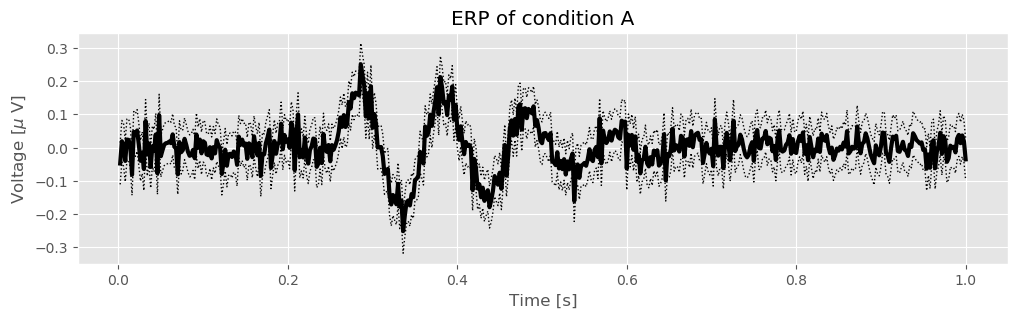

In [2]:
data = loadmat('matfiles/02_EEG-1.mat')  # Load the data,
EEGa = data['EEGa']  # ... and get the EEG from one condition,
t = data['t'][0]   # ... and a time axis,
ntrials = len(EEGa)  # ... and compute the number of trials.

mn = EEGa.mean(0)  # Compute the mean signal across trials (the ERP)
sd = EEGa.std(0)  # Compute the std of the signal across trials
sdmn = sd / sqrt(ntrials)  # Compute the std of the mean

figure(figsize=(12,3))  # Resize the figure
plot(t, mn, 'k', lw=3)  # Plot the ERP of condition A
plot(t, mn + 2 * sdmn, 'k:', lw=1)  # ... and include the upper CI
plot(t, mn - 2 * sdmn, 'k:', lw=1)  # ... and the lower CI
xlabel('Time [s]')  # Label the axes
ylabel('Voltage [$\mu$ V]')
title('ERP of condition A')  # ... provide a useful title
show()  # ... and show the plot

<div class="question">
    
**Q:** Try to read the code above. Can you see how it loads data, computes the event-related potential and error, and then plots the results?

**A:** If you've never computed an event-related potential before, that's an especially difficult question. Please continue on to learn this **and more**!
</div>

## Background <a class="anchor" id="background"></a>

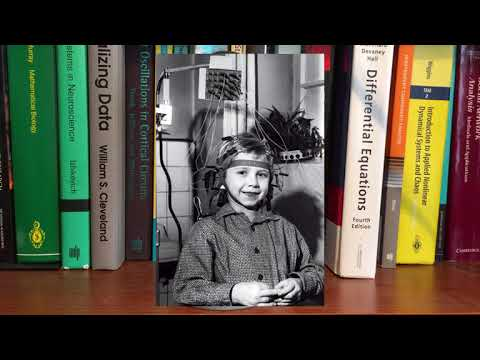

In [3]:
YouTubeVideo('Cy_BF7smAkk')
# NO CODE

Voltage recordings from the scalp surface - the electroencephalogram or EEG - provide a powerful window into brain voltage activity.  Some of the earliest human EEG recording occurred in 1924, when <a href="https://en.wikipedia.org/wiki/Hans_Berger" rel="external">Dr. Hans Berger</a> made a remarkable discovery:  the EEG of a human subject at rest with eyes closed exhibits rhythmic activity, an approximately 10 Hz oscillation he labeled the alpha rhythm.  Although now studied for nearly 100 years, the definitive functional role (if any) of the alpha rhythm remains unknown.  Since then, many other EEG rhythms have been detected and labelled (typically with Greek letters) and the analysis of EEG rhythms remains <a href="https://global.oup.com/academic/product/rhythms-of-the-brain-9780199828234" rel="external">an active area of research</a>. 

Compared to other modalities for measuring brain activity, the EEG possesses both advantages and disadvantages.  Perhaps the most important advantages are:

1. The EEG is non-invasive, and
2. The EEG permits a high temporal resolution (on the order of milliseconds).

However, the EEG measure also suffers from significant disadvantages, the most devastating being the poor spatial resolution;  a single scalp electrode detects the summed activity from approximately 10 cm<sup>2</sup> of cortex.

In this notebook, we consider EEG data recorded from a single scalp electrode.  We will analyze these data to determine what (if any) activity is evoked following two different types of stimuli presented to a human subject.  In doing so, we will use Python, and see how this powerful tool can help us understand these time series data.  We begin with a brief description of the EEG data.

[Return to top](#introduction)

## Case Study: an EEG ERP task <a class="anchor" id="case-study-data"><a/>

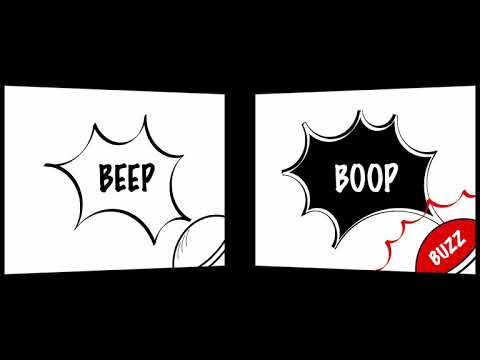

In [4]:
YouTubeVideo('q2-DjvPRaNA')
# NO CODE

An undergraduate student volunteers to participate in a psychology study at his university. In this study, EEG electrodes (sampling rate 500 Hz, i.e., 500 samples per second) are placed on the student's scalp, and he is seated in a comfortable chair in a dark, electrically isolated room.  The student is instructed to place headphones over his ears and listen to a series of repeated sounds.  The sounds consist of two tones - either a high pitch tone or a low pitch tone.  A single tone is presented once every few seconds, and the student responds with a button press to the low pitch tone.  The tone presentation is repeated to collect the EEG response to numerous presentations of the two tones, as illustrated here:

<img src="imgs/2-1.png">

In this cartoon illustration of the EEG experiment, the EEG electrodes are placed on the scalp surface of a human subject (left).  The EEG activity (blue) is recorded as a function of time during presentation of high pitch tones (black) and low pitch tones (orange).

Our collaborator leading this research study has agreed to provide us with EEG data recorded at a single electrode for 1000 presentations of the high pitch tone, and 1000 presentations of the low pitch tone.  In each presentation - or "trial" - she provides us with 1 s of EEG data, such that the tone occurs at 0.25 s into the trial.  She asks us to analyze these data to determine whether the EEG signal differs following the two tone presentations.

[Return to top](#introduction)

## Data Analysis <a id="data-analysis"></a>

Our first step is to load the data into Python.  To do so, we use the function `loadmat()` from the `scipy.io` module as follows:

In [5]:
from scipy.io import loadmat       # Import function to read data.
data = loadmat('matfiles/02_EEG-1.mat')

To understand the outcome of issuing this command, let's examine the variable `data` now present in the workspace.  This variable is a *dictionary* variable (to see this, execute `type(data)`). To see the *keys* of a dictionary, use the `keys()` method.

In [6]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'EEGa', 'EEGb', 't'])

The keys that start and end with two underscores ( `__` ) are private and contain information about the MATLAB file; we will not need those keys here. The variables that we are interested in here are `EEGa`, `EEGb`, and `t`. These correspond to the EEG data recorded in the two conditions (i.e., `EEGa` to condition A and `EEGb` to condition B) as well as a time axis (`t`). Let's extract these variables from the `data` dictionary.

In [7]:
EEGa = data['EEGa']
EEGb = data['EEGb']
t = data['t'][0]

You may notice that we specified index zero when we imported the variable `t`. This is because `t` is a vector (one-dimensional) rather than an array (multi-dimensional). The default behavior of `loadmat()` is to extract variables as ndarray types (to see this, execute `type(EEGa)`). Specifically, if we don't tell Python to import the <a href="https://en.wikipedia.org/wiki/Zero-based_numbering" rel="external">zeroth</a> (row) element of `data['t']` then `t` will have shape (1, 500), rather than (500,). There may be cases where this arrangement is preferred, but best practice is to convert the variable to a one-diminsional vector.

In [8]:
print(data['t'].shape)
print(t.shape)
print(len(data['t']))
print(len(data['t'][0]))

(1, 500)
(500,)
1
500


<div class="python-note">
    
In general, a single underscore at the beginning of a variable, function or method indicates that this object should be treated as *private*. Double underscores often indicate that Python will interpret this object with some special instructions. In both cases, for what we are doing, we can usually ignore an object that starts with an underscore.
</div>

Let's use the `whos` command to get some more information about the variables.

In [9]:
whos

Variable   Type                          Data/Info
--------------------------------------------------
EEGa       ndarray                       1000x500: 500000 elems, type `float64`, 4000000 bytes (3.814697265625 Mb)
EEGb       ndarray                       1000x500: 500000 elems, type `float64`, 4000000 bytes (3.814697265625 Mb)
data       dict                          n=6
fft        function                      <function fft at 0x109fd2050>
linalg     module                        <module 'numpy.linalg.lin<...>/numpy/linalg/linalg.py'>
mn         ndarray                       500: 500 elems, type `float64`, 4000 bytes
ntrials    int                           1000
power      builtin_function_or_method    <built-in method power of<...>te object at 0x109f9c9e0>
random     builtin_function_or_method    <built-in method random o<...>te object at 0x109f9c9e0>
sd         ndarray                       500: 500 elems, type `float64`, 4000 bytes
sdmn       ndarray                       500: 5

<div class="python-note">
    
We could also have used `EEGa.shape` to find out the dimensions of the variable `EEGa`.
</div>

In the *Data/Info* column we see *1000x500* for `EEGa` and `EEGb`.  Both variables are matrices with 1000 rows and 500 columns.  Our collaborator tells us that:
- each row corresponds to a separate trial, and
- each column to a point in time.

So there are 1000 total trials, each consisting of 500 time points.  As a matter of convenience, we define a new variable to record the number of trials:

In [10]:
ntrials = EEGa.shape[0]  # len(EEGa) would give the same result

The `shape` property of an array is a *tuple* that indicates the size of each dimension. Adding `[0]` at the end tells Python to give us only the first value in the tuple. Recall that Python indexing starts at 0. This variable will be useful later, as we'll see. In fact, we can assign two variables at the same time:

In [11]:
ntrials, nsamples = EEGa.shape

With this syntax:
- we assign the variable `ntrials` to the value `EEGa.shape[0]`, which is the number of rows.
- we assign the variable `nsamples` to the value `EEGa.shape[1]`, which is the number of columns.

<div class="question">

**Q.** Determine the size of the variable `EEGb`. How many rows and columns does it possess? Which dimension corresponds to trials and which corresponds to time?
</div>

<div class="python-note">
    
A *tuple* is another data structure in Python that is similar to an array or a list because it usually contains more than one element. Python treats each of these structures slightly differently, however. One of the most challenging things about starting with Python is learning to understand the different data structures. Here, we will mainly work with arrays, which are good for holding multidimensional data. If you are curious and want to know more about data structures, there is a very concise description <a href="http://thomas-cokelaer.info/tutorials/python/data_structures.html">here</a> to get you started.
</div>

[Return to top](#introduction)

### Visual Inspection <a id="visual-inspection"></a>

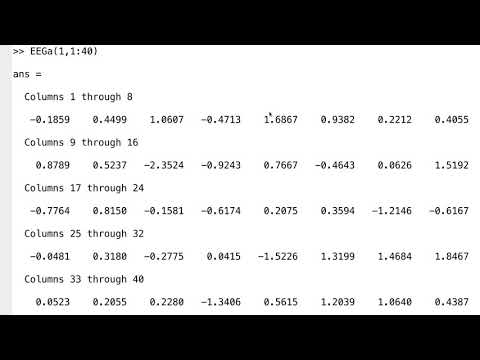

In [12]:
YouTubeVideo('uSjd41G-yNY')
# NO CODE

Both `EEGb` and `EEGa` are complicated variables that contain many elements. To understand these data, we might attempt to read the values contained in each element. For example, we can print out the EEG data for the first trial of condition A

In [13]:
print( EEGa[0] )  # EEGa[0, :] is equivalent to EEGa[0]

[-1.85909632e-01  4.49876010e-01  1.06070801e+00 -4.71265246e-01
  1.68669327e+00  9.38221338e-01  2.21207038e-01  4.05491276e-01
  8.78879665e-01  5.23697825e-01 -2.35240678e+00 -9.24345879e-01
  7.66671797e-01 -4.64254999e-01  6.25953180e-02  1.51917029e+00
 -7.76400815e-01  8.14988739e-01 -1.58137285e-01 -6.17402518e-01
  2.07506393e-01  3.59430871e-01 -1.21455008e+00 -6.16715452e-01
 -4.81362032e-02  3.17982689e-01 -2.77459585e-01  4.14839815e-02
 -1.52257779e+00  1.31993666e+00  1.46836023e+00  1.84666100e+00
  5.23163980e-02  2.05515379e-01  2.27994679e-01 -1.34063464e+00
  5.61451651e-01  1.20391968e+00  1.06398658e+00  4.38748238e-01
  1.64443736e+00 -1.54713823e+00  6.41177787e-01 -1.13319311e+00
  1.06869889e+00  3.88678297e-01 -1.86251056e+00 -1.14074604e+00
 -4.59323117e-01  7.46220184e-01  4.40752835e-01 -7.05129357e-01
 -1.85879610e-01 -4.52021194e-02 -7.74389189e-01  1.55051475e+00
  1.12600755e+00 -1.14703552e+00 -5.42577409e-02  8.27809465e-01
  8.56502531e-01 -1.14366

In this command, we index the first row of the matrix `EEGa` and print out all columns (corresponding to all moments of time).

<div class="question">

**Q.** Upon issuing this command what do you find? Does the printout help you understand these data?

**A.** You should observe a list of 500 numbers that begins 

    `-1.85909632e-01   4.49876010e-01   1.06070801e+00  -4.71265246e-01   1.68669327e+00   9.38221338e-01 ...`
    
We might conclude that these numbers exhibit variability (i.e., the values are both positive and negative), but examining the data in this way is not particularly useful. For example, determining trends in the behavior (such as intervals of repeated activity) through inspection of these printed numbers alone is extremely difficult.
</div>

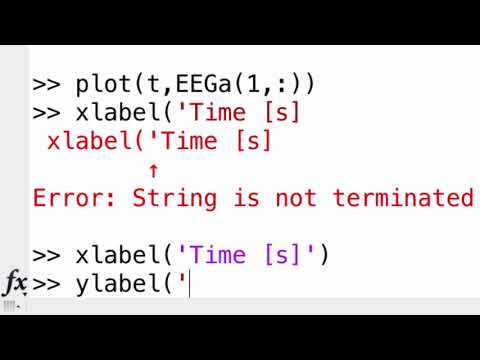

In [14]:
YouTubeVideo('9qx29zDxcAc')
# NO CODE

Printing out the data to the screen is **not useful** in this case. How else can we deepen our understanding of these data? Let’s make a plot:
<a id="fig:2"></a>

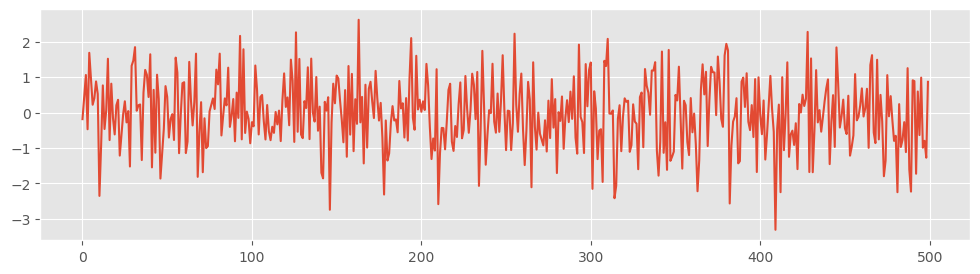

In [15]:
plot(EEGa[0])                   # Plot the data from condition A, trial 1.
savefig('imgs/2-2a')
show()

Visualizing the data in this way, we immediately notice many features. First, let’s consider the axes. The horizontal axis extends from 0 to (nearly) 500. This corresponds to the 500 columns in the variable `EEGa`. While this visualization is useful, it would be more informative to plot the EEG data as a function of time rather than indices. Fortunately, we possess a variable `t` in the workspace that corresponds to the time axis. Determining the size of the variable `t`, we find it is a vector with 1 row and 500 columns. Each column corresponds to a point in time.

<div class="question">
    
**Q.** Plot the variable `t`. What is its range? 
</div>

The variable `t` corresponds to the 1 s of EEG data recorded in each trial. We can also use the variable `t` to determine the sampling interval,

In [16]:
dt = t[1] - t[0]  # Determine the sampling interval

The new variable `dt` corresponds to the time between samples.

<div class="question">

**Q.** What is the value of `dt`? We were told by our collaborator that the sampling frequency is 500 Hz. Is the value of `dt` consistent with this sampling frequency?

**A.** Yes, it is consistent. Using the command `print(dt)`, we find that `dt` is 0.002 s, or 2 ms. The sampling frequency of 500 Hz corresponds to one sample of the EEG data every 1/(500 Hz) = 2 ms. If the two were not consistent, we would return to our collaborator and figure out what has gone wrong. In general, it’s useful to ask such questions along the way to make sure we understand the formatting of the data and catch any potentially serious misunderstandings early in the analysis.
</div>

<div id="singleTrial">
    
We can now combine the time axis with the EEG data to make a more complete plot. Let’s also label the axes and give the plot a title.

</div>

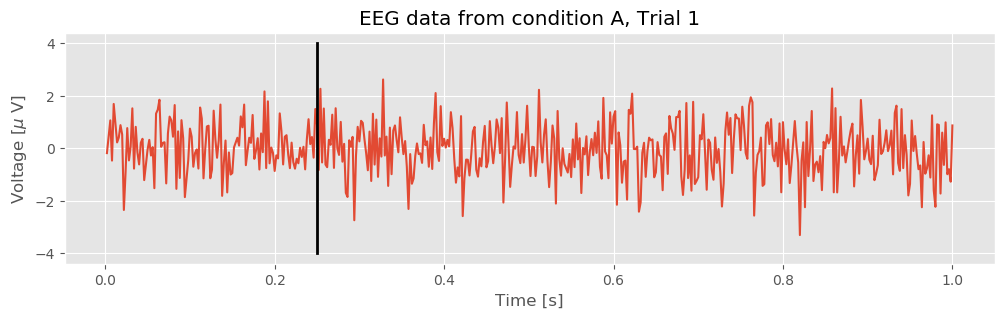

In [17]:
plot(t, EEGa[0])                     # Plot condition A, trial 1 data vs t.
xlabel('Time [s]')                   # Label the x-axis as time.
ylabel('Voltage [$\mu$ V]')          # Label the y-axis as voltage.
title('EEG data from condition A, Trial 1')  # Add a title

# Add a vertical line to indicate the stimulus time
plot([0.25, 0.25], [-4,4], 'k', lw=2)
savefig('imgs/2-2b')
show()

This plot provides a nice summary of the data in the first trial of condition A. Visual inspection of the plot suggests that these data exhibit complicated activity. We know from our collaborator that the stimulus occurs at time 0.25 s in each trial. Note how we indicated this time as a vertical line in the plot above. This command includes additional options that make the line black (`'k'`) and a bit wider (`lw=2`).

<div class="question">
    
**Q.** What else, if anything, can you say about the single trial of EEG data plotted above? Does the visual inspection reveal any particular change in the EEG activity following the stimulus presentation?
</div>

So far we have visualized only the data from condition A. Because we are interested in whether the EEG behaves differently in the two conditions, visualizing both conditions simultaneously would be of use. We can do this as follows:
<a id="fig:3"></a>

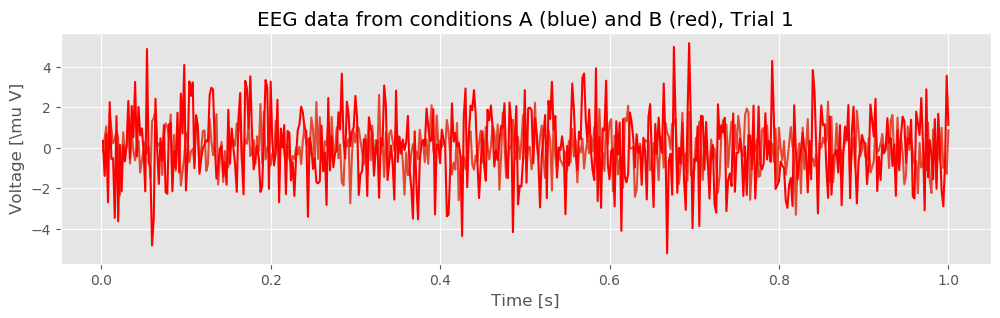

In [18]:
figure(figsize=(12, 3))     # Resize the figure to make it easier to see
plot(t,EEGa[0])                 # Plot condition A, trial 1, data vs t,
plot(t,EEGb[0], 'r')            # ... and the data from condition B, trial 1,
xlabel('Time [s]')              # Label the x-axis as time.
ylabel('Voltage [\mu V]')       # Label the y-axis as voltage.
title('EEG data from conditions A (blue) and B (red), Trial 1') # And give it a title.
savefig('imgs/2-3')
show()

<div class="question">
    
**Q.** Compare the voltage traces from the first trial of conditions A and B as plotted above. What similarities and differences do you observe?

</div>

<div class="question">
    
**Q.** The analysis has so far focused only on the first trial. Repeat this visual inspection of the data for different trials. What do you find? What similarities and differences exist between the two conditions across trials?
</div>

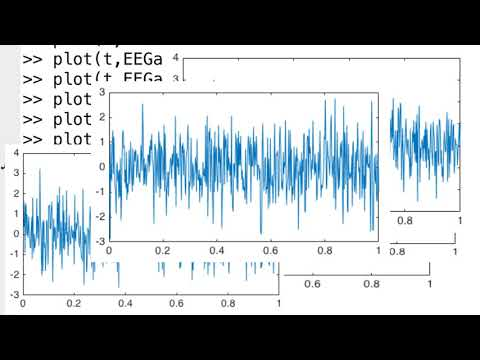

In [19]:
YouTubeVideo('nandZ5aaRaQ')
# NO CODE

These techniques allow us to visualize the data one trial at a time. That is useful but can be time consuming, especially for a large number of trials. For the EEG data of interest here, each condition contains 1,000 trials, and to visualize each trial separately could require 2,000 plots. We can certainly create 2,000 plots, but the subsequent visual inspection would be time consuming and difficult. Fortunately, a more efficient visualization approach exists: we can display the entire structure of the data across both time and trials as an image:
<a id="fig:4"></a>

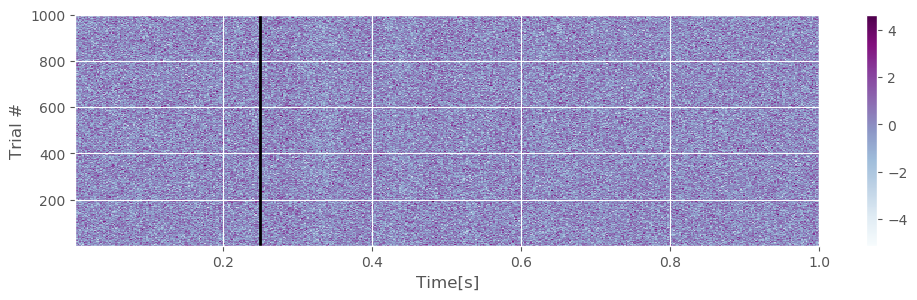

In [20]:
imshow(EEGa,                                   # Image the data from condition A.
           cmap='BuPu',                            # ... set the colormap (optional)
           extent=[t[0], t[-1], 1, ntrials],       # ... set axis limits (t[-1] represents the last element of t)
           aspect='auto',                          # ... set aspect ratio 
           origin='lower')                         # ... put origin in lower left corner
xlabel('Time[s]')                              # Label the axes
ylabel('Trial #')
colorbar()                                     # Show voltage to color mapping
vlines(0.25, 1, 1000, 'k', lw=2)       # Indicate stimulus onset with line
savefig('imgs/2-4')
show()

The `imshow` command allows us to visualize the entire matrix `EEGa` as a function of trial number and time. Each row corresponds to a single trial of duration 1 s, and the color indicates the voltage, with darker (lighter) colors indicating higher (lower) voltages. This plot also indicates the time of stimulus presentation with a vertical black line as a cue to assist visual inspection.

<div class="python-note">
    
We have used the *BuPu* color map for the plot above. There are many other options; use `colormaps?` for details.
</div>

<div class="question">
    
**Q.**
Upon close inspection of the figure above, what response, if any, do you observe following the stimulus presentation? (Look *really* carefully.) Repeat this visualization and analysis for `EEGb`. How do the two conditions compare?
</div>

[Return to top](#introduction)

### Plotting the ERP <a id="plotting-the-erp"></a>

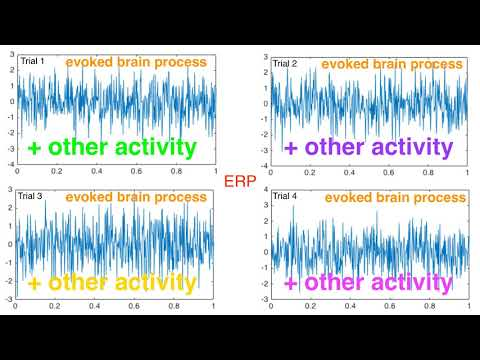

In [21]:
YouTubeVideo('kPr2GLSKLJg')
# NO CODE

Visual inspection of the EEG data has so far come up empty. The EEG traces appear noisy or perhaps rhythmic, but from visual inspection of the individual trials it’s difficult to make a decisive conclusion of underlying structure<span class="sup">fig<img src="imgs/2-2b.png"></span>. To further investigate the activity in these data, we compute the **event-related potential** (ERP).

To compute the ERP, we first assume that each trial evokes an instantiation of the same underlying brain process. So, in this case, we assume that the same brain response is evoked 1,000 times (once for each trial) for each condition. However, the evoked response due to the stimulus is small and hidden in the EEG signal by other ongoing activity unrelated to the stimulus (e.g., daydreaming, thoughts of dinner, thoughts of homework). Therefore, to tease out the weak evoked effect, **we average the EEG responses across trials**. Ideally, EEG activity unrelated to the stimulus will cancel out in the average, while EEG activity evoked by the stimulus will sum constructively. The procedure to perform and display this averaging can be done in Python as follows:
<a id="fig:5"></a>

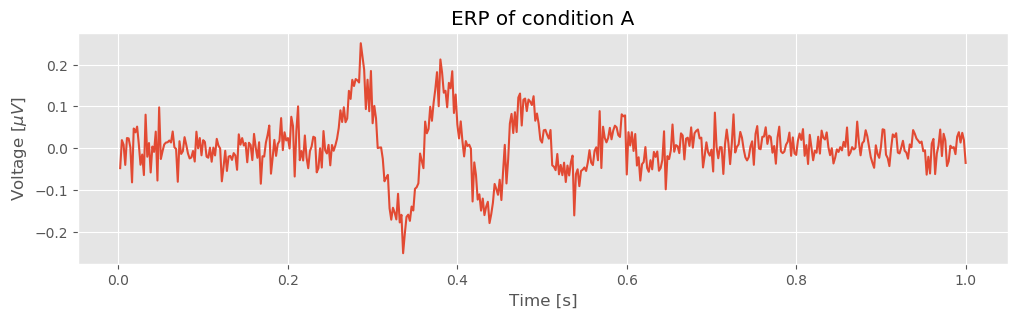

In [22]:
plot(t, EEGa.mean(0))  # Plot the ERP of condition A
xlabel('Time [s]')           # Label the axes
ylabel('Voltage [$\mu V$]')
title('ERP of condition A')  # ... provide a title
savefig('imgs/2-5')
show()                       # ... and show the plot

In the first line, we compute the mean of `EEGa` using the method `mean()` (see the documentation for this function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html" rel="external">here</a>). The default behavior is to compute the mean of all elements of the array. By calling `EEG.mean(0)`, we compute the mean along the zeroth dimension. The result is the ERP for condition A.

<div class="question">
    
**Q.** Consider the ERP for condition A plotted above. Update this figure to include a vertical line at the location of the stimulus, and the ERP for condition B. How, if at all, do the ERPs for Conditions A and B differ?

</div>

The ERP of condition A shows the mean voltage across trials at each moment in time. Visual inspection suggests that before stimulus presentation (i.e., times 0 s to 0.25 s) the EEG fluctuates around zero. Then, after stimulus presentation, the ERP increases and decreases substantially above and below zero. Which, if any, of these deviations following stimulation are significant? To address this, we make use of the trial structure of the EEG data to compute confidence bounds for the ERP. We do so in two ways.

[Return to top](#introduction)

### Confidence Intervals for the ERP (Method 1) <a id="cis-m1"></a>

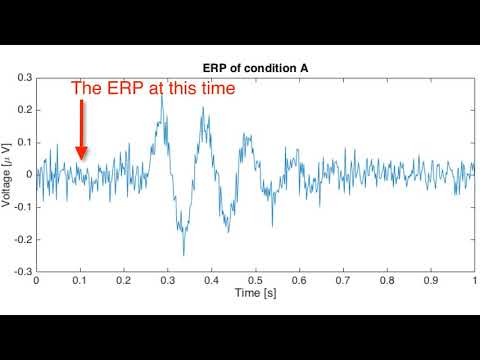

In [23]:
YouTubeVideo('pXCJbyrw8Ug')
# NO CODE

To compute the ERP we average the EEG data across many trials. Because of this, we may make use of a powerful theorem in statistics—the <a href="https://en.wikipedia.org/wiki/Central_limit_theorem" rel="external">*central limit theorem*</a> (CLT)—to include approximate confidence bounds in the ERP figure. Briefly, this theorem states that the mean of a sufficiently large number of independent random variables, each with finite mean and variance, will be approximately <a href="https://en.wikipedia.org/wiki/Normal_distribution" rel="external">normally distributed</a>. Remember that the ERP at each moment in time is the sum of EEG activity across trials (then scaled by a constant, the number of trials). Let’s assume that the trials are independent (i.e., one trial does not depend on any other trial). Let’s also assume that the EEG data at each moment in time have finite mean and variance. With those assumptions, we have satisfied the CLT and may therefore conclude that the ERP at each moment in time is approximately normally distributed.

<div class="question">
    
**Q.** To use the CLT, we make two assumptions about the EEG data. Are these assumptions reasonable?

**A.** We assume that the EEG data are independent across trials. This assumption may fail if, for example, the activity in one trial influences the activity in the next trial. We also assume that the EEG data are “well-behaved” (i.e., have finite mean and variance). That is a reasonable assumption for physical data we observe from the brain; we expect the EEG data to always remain finite and not diverge to plus or minus infinity.

</div>

This conclusion—that the ERP at each moment in time is approximately normally distributed—is useful because the normal distribution (also known as the Gaussian distribution or bell curve) possesses many convenient properties. First, a normal distribution is relatively simple; it can be completely specified with two parameters: the mean value and the standard deviation. Second, 95% of the values drawn from a normal distribution lie within approximately two standard deviations of the mean.

<img src="imgs/gaussian.png" alt="Example Gaussian" style="width:40%; max-width:300px;"/>

Here's a plot of the canonical normal distribution showing the mean (dotted vertical line) and standard deviation (blue). Ninety-five percent of values lie within the interval indicated by the red bar.

Therefore, to construct a 95% confidence interval for the ERP, we need to determine the mean and standard deviation of the mean across trials at each point in time. To compute the mean in Python is easy:

In [24]:
mn = EEGa.mean(0)  # Compute the mean across trials (the ERP)

<div class="python-note">
    
Note that when we refer to the *mean* here we could instead write *sample mean* because we use the observed data to estimate the theoretical mean that we would see if we kept repeating this experiment. This distinction is not essential to our goals here, but it is important when talking to your statistics-minded colleagues. Throughout the book, we omit the term sample when referring to sample means, variances, covariances, and so forth, unless this distinction is essential to the discussion.

</div>

We again note that the second input to the `mean` function specifies the dimension in which we compute the mean, in this case, across the first dimension of the variable `EEGa` corresponding to the trials. To compute the standard deviation of the mean, we start by computing the standard deviation of the data:

In [25]:
sd = EEGa.std(0)  # Compute the std across trials

But we’re not interested in the standard deviation of the EEG data across trials; instead, we’re interested in the standard deviation *of the estimate of the mean*. To calculate the standard deviation of the mean, we divide the standard deviation of the data by the square root of the number of trials (i.e., the number of terms used to compute the mean). In Python,

In [26]:
sdmn = sd / sqrt(ntrials)  # Compute the std of the mean

Now, having found the mean (`mn`) and the standard deviation of the mean (`sdmn`), we can compute a 95% confidence interval for the ERP. We again exploit the observation, based on the central limit theorem, that the ERP is normally distributed at each instant of time. With these calculations, the following code plots the ERP and the 95% confidence interval:

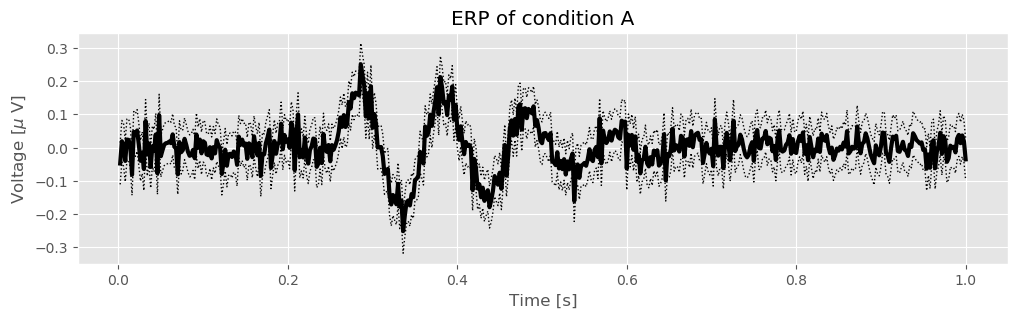

In [27]:
fig, ax = subplots(figsize=(12, 3))     # Save the axes for use in later cells and resize the figure
ax.plot(t, mn, 'k', lw=3)              # Plot the ERP of condition A
ax.plot(t, mn + 2 * sdmn, 'k:', lw=1)  # ... and include the upper CI
ax.plot(t, mn - 2 * sdmn, 'k:', lw=1)  # ... and the lower CI
xlabel('Time [s]')                     # Label the axes
ylabel('Voltage [$\mu$ V]')
title('ERP of condition A')            # ... provide a useful title
fig                                    # ... and show the plot
show()

The ERP computed with confidence intervals allows us to ask specific questions about the data. For example, does the ERP ever differ significantly from zero? To answer this, we look for intervals of the ERP for which the confidence intervals do not include zero. To aid visual inspection, we add to the ERP plot a horizontal line at 0: <a id="plt:erpA-m1"></a>

<div class="python-note">
    
A good rule of thumb when you are programming is that you should not be rewriting (or copy-pasting) code over and over again. Instead, you should write a function that you can call whenever you need the action that you keep repeating. At this point, we have resized the plots and labeled the axes the same way several times so we should fix the default plot size and write a function that automates the labeling so that next time we make a plot, we don't need to rewrite the same code again.
</div>

In [28]:
# Change the default figure size
rcParams['figure.figsize'] = (12, 3)

# Create a function to label plots
def labelPlot(title_string="Title"):
    '''
    A function that labels the x-axis as 'Time [s]' and
    the y-axis as 'Voltage [$\mu V$]'. 
    Arguments:
        title_string:  string variable to be used as
                       the plot title (default: 'Title')
                       
    '''
    xlabel('Time [s]')           # x-axis is time
    ylabel('Voltage [$/mu V$]')  # y-axis is voltage
    title(title_string)          # use the input here
    autoscale(tight=True)    # no white-space in plot

<div class="question">
    
**Q.** How would you write a function to compute the ERP and confidence bounds of a dataset?

</div>

<div class="question">
    
**Q.** What do you think the following code will do?

       `ax.hlines(0, t[0], t[-1])`

Try it out.

</div>

<div class="question">
    
**Q.** What is the role of the method function `hlines()` in this code? *Hint*: If you have not encountered this function before, look it up in the Documentation.

</div>

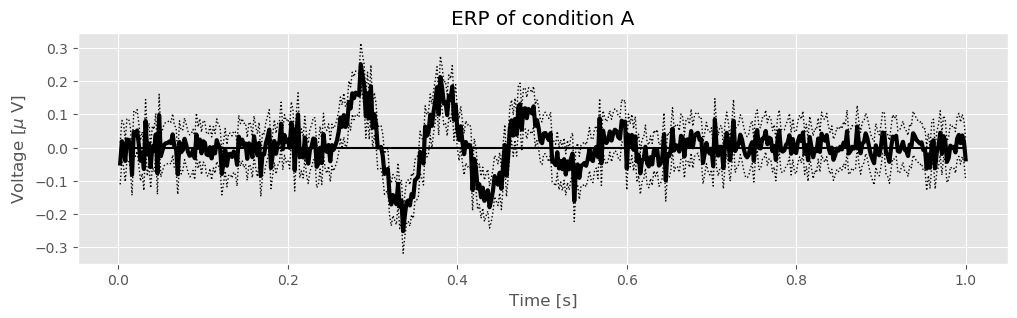

In [29]:
ax.hlines(0, t[0], t[-1])
fig.savefig('imgs/2-7')
fig

In the figure above, the thick line indicates the ERP for Condition A (i.e., the mean of the EEG across trials) while the thin dotted lines indicate the 95% confidence intervals.

We find three time intervals at which the confidence intervals of the ERP do not include zero: near 0.27 s, near 0.37 s, and near 0.47 s. These results suggest that for an interval of time following the stimulus presentation in condition A, the observed ERP is not a random fluctuation about zero but instead contains consistent structure across trials.

<div class="question">
    
**Q.** Construct the ERP with confidence intervals for condition B. As for condition A, you should find that before stimulus presentation the ERP fluctuates around zero. What intervals of time, if any, differ significantly from zero?
</div>

[Return to top](#introduction)

### Comparing ERPs <a class="anchor" id="comparing-erps"></a>

In the previous section, we implemented a procedure to compute confidence intervals for the ERPs in conditions A and B. To investigate *differences* between the ERPs in the two conditions, we can use a similar approach. To start, let’s plot the ERPs with confidence intervals for both conditions and attempt to identify periods for which the confidence intervals do not overlap (such intervals would correspond to significant differences between the responses of the two conditions).

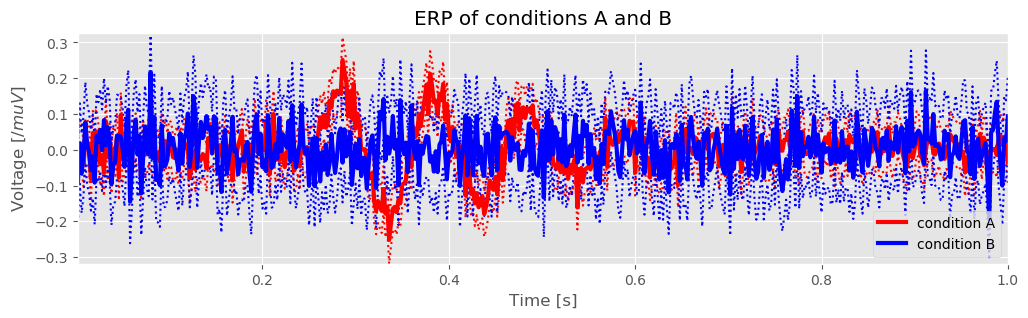

In [30]:
from my_module import ERP  # A function written by the author to compute the ERP

erpA, ca_l, ca_h = ERP(data['EEGa'])  # Compute the ERP of condition A
erpB, cb_l, cb_h = ERP(data['EEGb'])  # ... and condition B

plot(t, ca_l, 'r:', t, ca_h, 'r:')  # Plot confidence bounds in back
plot(t, cb_l, 'b:', t, cb_h, 'b:')
plot(t, erpA, 'r', lw=3, label='condition A')  # ... and ERPs in front
plot(t, erpB, 'b', lw=3, label='condition B')

# Prettify
labelPlot('ERP of conditions A and B')
legend()
savefig('imgs/2-8a')
show()

<div class="question">
    
**Q.** In the cell above, the ERPs and confidence bounds are computed using a function written by the author. Can you write the code to make this plot yourself?
</div>

As you can see, the plot of both ERPs is rather messy; it’s difficult to determine through visual inspection alone in which intervals the ERPs exhibit significant separation.

To facilitate further inspection of the data, we compute the difference between the ERPs in the two conditions. In the differenced signal, large deviations between the two conditions will appear as large differences from zero. To determine whether a deviation is significantly different from zero, we need to determine the confidence interval for the differenced ERP. This requires we propagate the standard deviation of the mean for both ERPs to the new differenced ERP. The propagated standard deviation of the mean at a fixed moment in time is computed as:

<a id="eq:1"></a>
$$ 
  \sigma = \sqrt{\frac{\sigma_A^2}{K} + \frac{\sigma_B^2}{K}}, \tag{1}
$$

where $\sigma_A$ is the standard deviation of the data from condition A, $\sigma_B$ is the standard deviation of the data from condition B, and $K$ is the number of trials.

In Python we compute the differenced ERP and standard deviation of the mean of the difference as follows:
<a id="plt:differencedERP"></a>

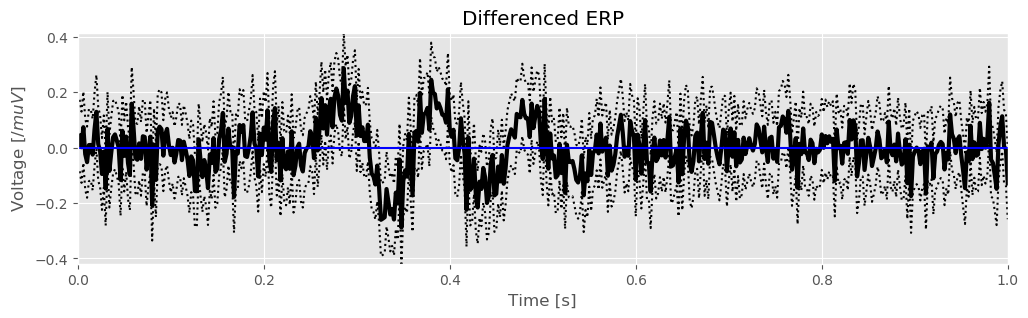

In [31]:
mnA = EEGa.mean(0)  # ERP of condition A
sdmnA = EEGa.std(0) / sqrt(ntrials)  # ... and standard dev of mean

mnB = EEGb.mean(0)  # ERP of condition B
sdmnB = EEGb.std(0) / sqrt(ntrials)  # ... and standard dev of mean

mnD = mnA - mnB  # the differenced ERP
sdmnD = sqrt(sdmnA ** 2 + sdmnB ** 2)  # ... and its standard dev

plot(t, mnD, 'k', lw=3)  # plot the differenced ERP
plot(t, mnD + 2 * sdmnD, 'k:')  # ... the upper CI
plot(t, mnD - 2 * sdmnD, 'k:')  # ... and the lower CI
plot([0, 1], [0, 0], 'b')  # ... and a horizontal line at 0
labelPlot('Differenced ERP')  # label the plot
show()

In the code above we first compute the ERP and standard deviation of the mean for each condition. We then compute the differenced ERP (`mnD`) and the standard deviation of the mean of this difference (`sdmnD`)<span href="#eq:1" class="sup">eq<img src="imgs/eq1.png"></span>. We note that `sdmnA`$= \sqrt{\sigma_A^2/K}$ and therefore `sdmnA**2` $= \sigma_A^2/K$, with similar expressions for condition B. We then plotted the resulting differenced ERP with 95% confidence intervals. The hope is that from this figure we can more easily identify significant differences between the two conditions.

<div class="question">
    
**Q:** Examine the plot of the differenced ERP. In what intervals of time do the EEG responses in the two conditions significantly differ?
</div>

[Return to top](#introduction)

### Confidence Intervals for the ERP (Method 2) <a id="cis-m2"></a>

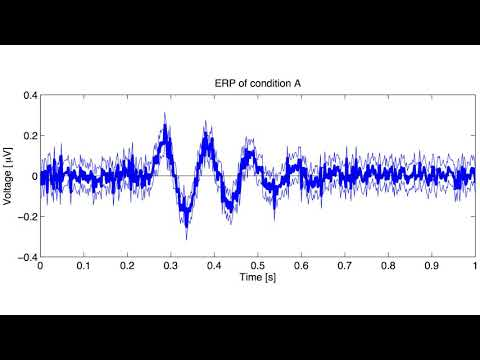

In [32]:
YouTubeVideo('vVXH4XsPFEs')
# NO CODE

So far we have computed confidence intervals for the ERPs by relying on the central limit theorem and approximating the average voltage values at each point in time as normally distributed. That’s a completely reasonable approach. And because the normal distribution is so well-behaved, it’s easy to compute the 95% confidence intervals. An alternative approach to generate confidence intervals is through a **bootstrap** procedure. Bootstrapping is a resampling method that allows us to estimate the sampling distribution of many different statistics. In this notebook, we implement a *nonparametric bootstrap* (see note). To do so, we generate new *pseudodata* from the observed EEG data. We begin by using a bootstrapping procedure to create confidence intervals for the ERPs observed in each condition.

<div class="math-note">
    
**A note on the nonparametric bootstrap.** Briefly, there is strong theoretical justification for the nonparametric bootstrap. The fundamental idea is that resampling the data with replacement is equivalent to sampling new pseudodata from the empirical cumulative distribution function (eCDF) of the observed data. For a large sample of independent, identically distributed random variables, the distribution of the pseudodata generated from the eCDF will be close to the true distribution of the data. Note the important caveat that the variables are independent, identically distributed; this assumption fails in many cases, such as for time series. Here, we assume that each trial is drawn independently from the same distribution (i.e., the trials are independent, identically distributed variables).
</div>

We implement the bootstrapping procedure to compute pointwise confidence intervals. By pointwise we mean that the confidence intervals are computed separately for each point in time, and interactions across time are not considered. The prescription for the bootstrapping procedure follows four steps:

1. Sample with replacement 1,000 trials of the EEG data from condition A.
1. Average these 1,000 trials to create a resampled ERP.
1. Repeat these two steps 3,000 times to create a distribution of ERPs.
1. For each time point, identify the values greater than 2.5% and less than 97.5% of all 3,000 values. This range determines the 95% confidence interval for the ERP for that time point.

Let’s now implement each step in Python.

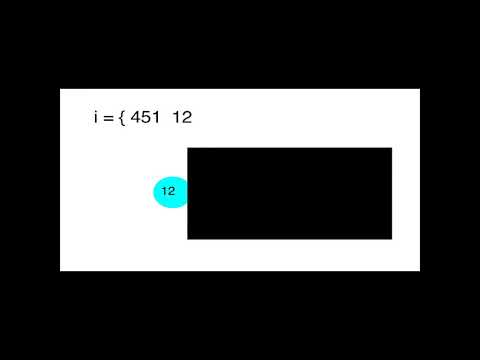

In [33]:
YouTubeVideo('mqDEJyW_z4c')
# NO CODE

**Step 1.** In step 1 we must sample with replacement from the EEG data. To visualize this procedure, imagine placing 1,000 marbles in an opaque bag. Each marble is assigned a unique integer value from 1 to 1,000. Now, reach your hand into the bag, grab a marble, record its number, and replace the marble in the bag. We assume that each marble is equally likely to be selected at each draw (i.e., there are no special features that allow some marbles to be drawn more often). Repeat this procedure 1,000 times to create a list of 1,000 integers. Notice that after recording the drawn marble’s number, we replace it in the bag. So, we could potentially draw the same marble 1,000 times, although that’s extremely unlikely. Performing this sampling with replacement procedure by hand would, of course, be extremely time consuming (e.g., who will paint integers on each marble?). Fortunately, Python provides a function to perform sampling with replacement:

In [34]:
# Draw 1000 integers with replacement from [0, 1000)
i = randint(0, ntrials, size=ntrials)

The first and second inputs to `randint()` specify the minimum and maximum integers to draw, respectively. Note that the low number is included in the set, but the high number is not. If only the upper bound is given, the lower bound is assumed to be zero (i.e., we can rewrite the above line as `randint(ntrials, size=ntrials)`). The last input indicats the number of samples to draw (as always, use `randint?` to find out more).

<div class="question">
    
**Q.** Examine the values of `i`. What values do you find?
</div>

The result `i` provides a list of integers between 0 and 999. These values specify the trials to use in creating the resampled EEG. This resampled EEG will contain the same number of trials as the original EEG (i.e., 1,000 trials) but in a different order and with possibly repeated trials. For example, if the sampling with replacement procedure returns

    i = [10, 941, 3, 400, 10, ...

then the first and fifth trials of the resampled EEG will equal the eleventh trial of the original EEG (remember that Python indices start at zero). We create the resampled EEG in Python as follows:

In [35]:
EEG0 = EEGa[i]  # Create the resampled EEG.

In this code we use the variable `i` as the index to the rows of `EEGa`.

<div class="question">
    
**Q.** What is the `shape` of the new variable `EEG0`? Is this shape consistent with the original EEG datasets?
</div>

That completes step 1 of the resampling procedure.

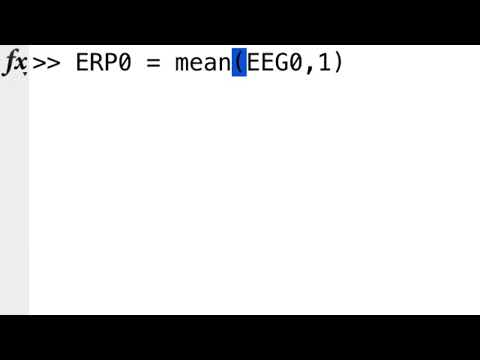

In [36]:
YouTubeVideo('bUzuNojLUik')
# NO CODE

**Step 2.** This step is easy: we create a resampled ERP from the resampled EEG data. Computing the resampled ERP requires only one line of code in Python:

In [37]:
ERP0 = EEG0.mean(0)  # Create the resampled ERP

<div class="question">
    
**Q.** What is the difference between the resampled EEG and resampled ERP? Explain your answer in words.
</div>

<div class="question">
    
**Q.** Plot the resampled ERP that we created. What does it look like?
</div>

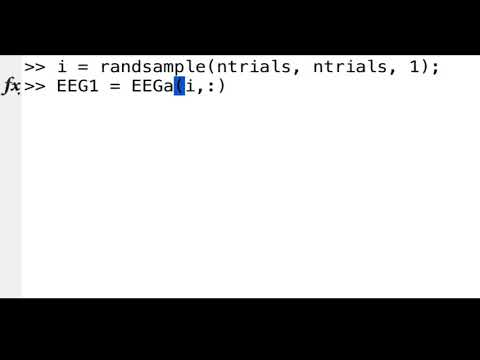

In [38]:
YouTubeVideo('feQk_vKloXk')
# NO CODE

**Step 3.** In the first two steps of the resampling procedure we created a single resampled ERP. In step 3 we are instructed to repeat this procedure 3,000 times and create a distribution of ERPs. How can we do so? One potential solution is to cut and paste the code we developed over and over again, for example:

In [39]:
i = randint(ntrials, size=ntrials);  # Draw integers,
EEG1 = EEGa[i];  # ... create resampled EEG,
ERP1 = EEG1.mean(0);  # ... create resampled ERP.

i = randint(ntrials, size=ntrials);  # Draw integers,
EEG2 = EEGa[i];  # ... create resampled EEG,
ERP2 = EEG2.mean(0);  # ... create resampled ERP.

i = randint(ntrials, size=ntrials);  # Draw integers,
EEG3 = EEGa[i];  # ... create resampled EEG,
ERP3 = EEG3.mean(0);  # ... create resampled ERP.

In these lines we have created three resampled ERPs, each with its own variable name. We could, of course, repeat this procedure and eventually define the variable `ERP3000`.

<div class="question">
    
**Q.** Is defining the resampled ERPs in this way a good idea?

**A.** No! We should let the computer execute this repeated procedure for us. If you find yourself cutting and pasting the same code over and over again, you're probably doing something inefficient, inelegant, and error-prone.
</div>

A better approach to create the 3,000 resampled ERPs is with a *for-loop*. We do so in Python with the `for` statement:

In [40]:
def bootstrapERP(EEGdata, size=None):  # Steps 1-2
    """ Calculate bootstrap ERP from data (array type)"""
    ntrials = len(EEGdata)  # Get the number of trials
    if size == None:  # Unless the size is specified,
        size = ntrials  # ... choose ntrials
    i = randint(ntrials, size=size)  # ... draw random trials,
    EEG0 = EEGdata[i]  # ... create resampled EEG,
    return EEG0.mean(0)  # ... return resampled ERP.

ERP0 = [bootstrapERP(EEGa) for _ in range(3000)]  # Step 3: Repeat 3000 times 
ERP0 = array(ERP0)  # ... and convert the result to an array

In the first line, we define a function that performs the calculations that we wish to repeat. In this case, the function performs steps 1 and 2 of the bootstrapping procedure. The last two lines call the function 3,000 times and convert the result from a *list* into an *array*. This completes step 3 of the bootstrapping procedure.

<div class="python-note">
    
Note that in the definition of `bootstrapERP`, we included an argument (`size`) that has a *default* value (`None`). This lets us assume that we want the resampled dataset to be the same size as the original, which is true for right now. Later, however, we will reuse this function but will not want the resampled data to be the same size as the original.
</div>

<div class="python-note">
    
In Python it is common to see for-loops written in the form

    `y = [f(x) for x in some_set]`

This will return a *list* datatype, which is why we had to convert it to an array in the code above. We could also have written the loop in an alternative way:


    `ERP0 = zeros((3000, EEGa.shape[1]))`
    
    `for k in range(3000):`
    
    `    ERP0[k, :] = bootstrapERP()`

Note that it is good practice, but not required, to define a function that contains the code you wish to repeat, especially if you might use it again later. This minimizes rewrites, and if there is a mistake then you only need to make a correction in one place.
</div>

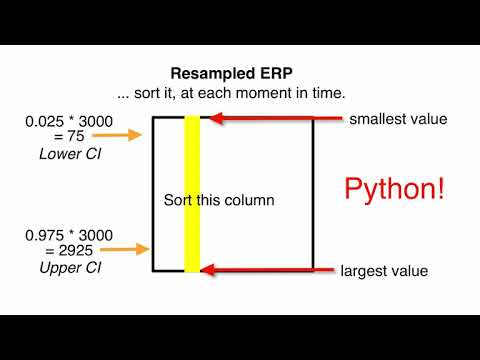

In [41]:
YouTubeVideo('NLc93QESVZs')
# NO CODE

**Step 4.** In this step of the bootstrapping procedure, we determine for each time point the values greater than 2.5% and less than 97.5% of all values. There are many ways to perform this operation in Python, perhaps the easiest being to sort from smallest to largest the 3,000 resampled ERP values at each time point. With the resampled values sorted in this way, we then find the resampled ERP value at index $0.025 \times 3000 = 75$ and $0.975 \times 3000 = 2925$. These indices correspond to the resampled ERP values greater than 2.5% of all values and greater than 97.5% of all values, respectively, and therefore define the lower and upper confidence intervals at each moment in time. We can compute both confidence intervals in Python, and (at last!) plot the ERP for condition A with confidence intervals computed using the bootstrapping procedure: <a id="fig:1"></a>

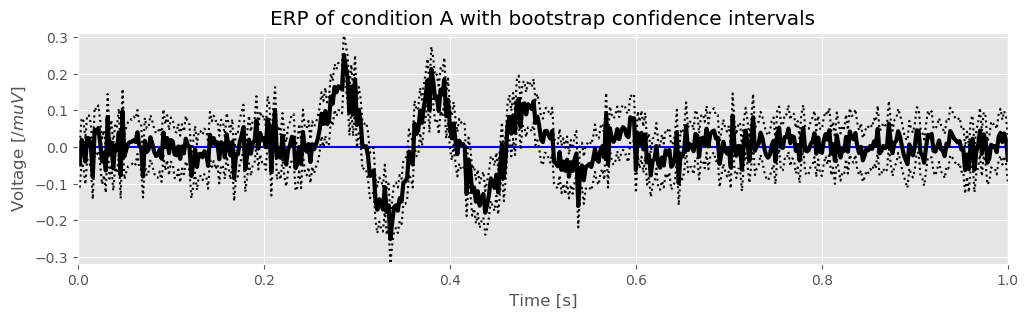

In [42]:
ERP0.sort(axis=0)  # Sort each column of the resampled ERP
N = len(ERP0)  # Define the number of samples
ciL = ERP0[int(0.025*N)]  # Determine the lower CI
ciU = ERP0[int(0.975*N)]  # ... and the upper CI
mnA = EEGa.mean(0)  # Determine the ERP for condition A
plot(t, mnA, 'k', lw=3)  # ... and plot it
plot(t, ciL, 'k:')  # ... and plot the lower CI
plot(t, ciU, 'k:')  # ... and the upper CI
hlines(0, 0, 1, 'b')  # plot a horizontal line at 0
                      # ... and label the axes
labelPlot('ERP of condition A with bootstrap confidence intervals')  # We define this function above!

We can use these results to identify, for example, intervals in which the ERP differs significantly from zero by finding periods in which the confidence intervals do not include zero. The advantage of the bootstrapping procedure over other approaches is that this procedure requires few assumptions about the distribution of the statistic of interest, and that we use the observed data to probe the distribution of the statistic. The disadvantage of the bootstrapping procedure is that it is computationally intensive. Here we considered 3,000 resamplings, but we could easily consider more.

<div class="question">
    
**Q.** Compare the confidence intervals in the plot above (bootstrap confidence intervals) to [the CLT confidence intervals](#plt:erpA-m1) computed earlier. How are the two results similar or different? What happens to the confidence intervals if you change the number of resamplings in step 3 from 3,000 to 10,000?
</div>

<div class="question">
    
**Q.** Compute the confidence intervals using the bootstrapping procedure for the ERP of condition B. What do you find?
</div>

[Return to top](#introduction)

### A Bootstrap Test to Compare ERPs <a id="bootstrap"></a>

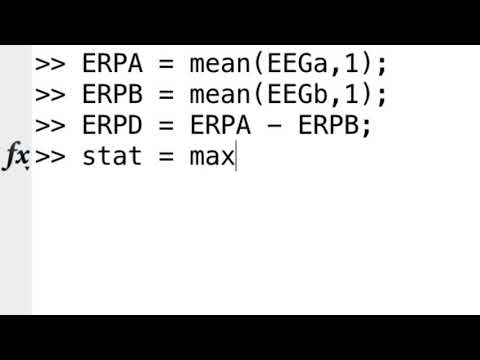

In [43]:
YouTubeVideo('K6pgCxFdELc')
# NO CODE

The bootstrapping procedure provides a powerful technique to construct confidence intervals for the ERPs using only the observed EEG measurements. We can apply a similar technique to search for significant differences between the ERPs in conditions A and B. To do so, we first choose a *statistic*, a measure of some attribute of the difference between the two ERPs. There are many choices, some informative and some not. Let’s choose as our statistic the maximum absolute value of the difference in the ERPs across time. Computing this statistic is straightforward in Python:

In [44]:
mbA = mean(EEGa,0)          # Determine ERP for condition A
mnB = mean(EEGb,0)          # Determine ERP for condition B
mnD = mnA - mnB                # Compute the differenced ERP
stat = max(abs(mnD))        # Compute the statistic
print('stat = {:.4f}'.format(stat))

stat = 0.2884


<div class="question">
    
**Q.** Given the value we determined for `stat`, are the ERPs for the two conditions different?
</div>

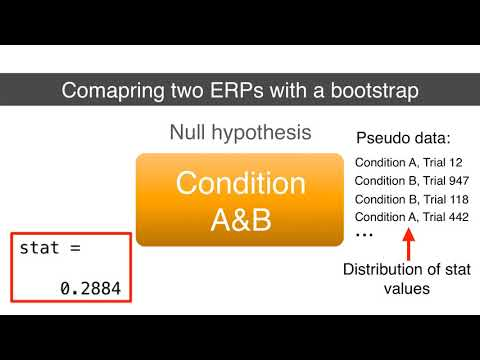

In [45]:
YouTubeVideo('390ywma7S3U')
# NO CODE

In isolation, the numerical value for `stat` is not very useful or interesting. Is the value for `stat` consistent with noisy scalp EEG data lacking an evoked response? Or is the value for `stat` large and unexpected to occur unless the ERPs in the two conditions are different? To make the statistic useful, we need `stat` to be interpretable, which we pursue here through a bootstrapping procedure. We assume that no difference exists between the two conditions; in the language of statistics, this is called the <a href="https://en.wikipedia.org/wiki/Null_hypothesis" rel="external">*null hypothesis*</a>. If the null hypothesis holds, then we can pool all the EEG signals together from both conditions (for a total of 2,000 trials) and draw from this combined distribution to create resampled ERPs representative of either condition.

It may seem odd to create pseudodata by selecting trials across both conditions; intuitively, we may expect the data to differ in these two conditions and feel uncomfortable making a pseudodata set that includes trials from both conditions. But under the null hypothesis, we assume no difference between the EEG responses in conditions A and B, and we are therefore free to create pseudodata drawing from trials in both conditions. We do so with the goal of creating a distribution of values for `stat` under the null hypothesis that conditions A and B exhibit no difference. We then compare the observed value of `stat` with this distribution of `stat` values. If there is a difference between the two conditions, we expect to find the observed value of `stat` to be very different from the distribution of `stat` values generated from the pseudodata under the null hypothesis.

To create the distribution of `stat` values under the null hypothesis of no difference between the two conditions, we perform a bootstrap test. The idea is similar to the bootstrapping procedure used to construct the [confidence intervals for the ERP](#fig:1)<span class="sup">fig<img src="imgs/2-1.png"></span>. We proceed as follows:

1. Merge the 1,000 trials each of EEG data from conditions A and B to form a combined distribution of 2,000 trials.
1. Sample with replacement 1,000 trials of EEG data from the combined distribution, and compute the resampled ERP.
1. Repeat step 2 and compute a second resampled ERP.
1. Compute the statistic, the maximum absolute value of the difference between the two resampled ERPs.
1. Repeat steps 2-4, 3,000 times to create a distribution of statistic values.
1. Compare the observed statistic to this distribution of statistic values. If the observed statistic is greater than 95% of the bootstrapped values, then reject the null hypothesis that the two conditions are the same.

The code to implement this procedure is similar to the bootstrapping procedure that we have already implemented to compute the confidence intervals for the ERP:

In [46]:
EEG = vstack((EEGa, EEGb))  # Step 1. Merge EEG data from all trials
seed(123)  # For reproducibility

def bootstrapStat(EEG):  # Steps 2-4.
    mnA = bootstrapERP(EEG, size=ntrials)  # Create resampled ERPa. The function 'bootstrapERP' is defined above!
    mnB = bootstrapERP(EEG, size=ntrials)  # Create resampled ERPb
    mnD = mnA - mnB  # Compute differenced ERP
    return max(abs(mnD))  # Return the statistic

statD = [bootstrapStat(EEG) for _ in range(3000)]  # Resample 3,000 times

In this code, we first combine `EEGa` and `EEGb` in a new variable `EEG`.
Then, as before, we define the function `bootstrapStat` which performs the operations that we wish to repeat. Both of the first two lines of the function call `bootstrapERP`, the function that we defined earlier to compute a resampled ERP. Note that in this case, we call `bootstrapERP` with `size=ntrials`. When we combined the original datasets in `EEG`, we generated a dataset with twice the number of trials, but we still wish to perform the bootstrap procedure to create a resampled ERP using the original number of trials (1,000). The last two lines of the function compute the resampled difference and return the statistic. Finally, we repeat the procedure 3,000 times using a for-loop.

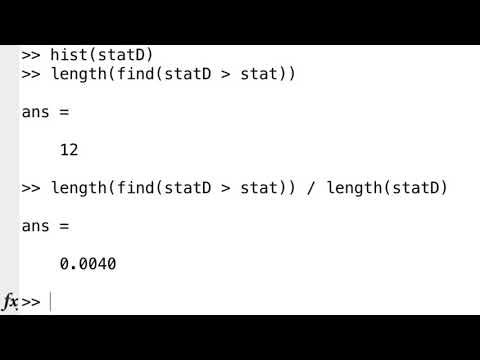

In [47]:
YouTubeVideo('iefCPGHd5vY')
# NO CODE

<img alt="Bootstrap distribution of statistic values" title="" src="imgs/bootstrapERPdiff.png" height="20" width="600">

The figure above shows the distribution of values for the test statistic under the null hypothesis of no difference between the two conditions. The orange line indicates observed statistic from the EEG data.

<div class="python-note">
    
The `seed()` function controls the random numbers that are generated. This ensures that when you recreate the plot above, yours will look identical. Nonetheless, if you remove (or comment out) this statement, your plot should still look very similar as the distribution should change only slightly.
</div>

<div class="question">
    
**Q.** See if you can write code to generate this plot using the `hist()` function from the NumPy module. 
</div>

<div class="question">
    
**Q.** Given the distribution of `statD` values shown above, and the value of `stat` computed from the original data, can we conclude that the difference between the two conditions is significant with this statistic?

**A.** Yes. Under the null hypothesis, the distribution fo the statistic ranges from approximately 0.15 to 0.33. The observed statistic `stat = 0.2884` exceeds most values in this distribution. Computing `sum(statD > stat)` we find in this example that only 18 of the 3,000 values in the distribution exceed the observed statistic. This corresponds to a proportion of 18/3000 = 0.006. We therefore reject the null hypothesis of no difference between the ERPs of conditions A and B. This result may be surprising, given how similar the two ERPs appear and the large variability in their differences ([see figure](#plt:differencedERP)).
</div>

This result illustrates the power of the bootstrapping procedure. We proposed a complicated statistic (the maximum absolute value of the difference between the two resampled ERPs). For this statistic, we do not possess an obvious formula to decide whether the resulting statistic is significant (we cannot rely on the CLT, for example). To determine significance, we employ a bootstrapping procedure (also known as a permutation test), which we can perform even for the relatively complicated statistic. In this way, we may devise complicated measures of data and construct error bars or compute statistical significance, provided our computational resources are sufficient.

[Return to top](#introduction)

## Summary <a id="summary"></a>

In this notebook, we considered scalp EEG data recorded from a single electrode during an auditory task. The task consisted of two conditions, and we sought to uncover the difference in the EEG responses between the two conditions. We began with a visual inspection of the EEG recordings from individual trials and from all trials, and concluded that the data were quite noisy; any evoked response due to the stimulus was not obvious in the single-trial data.

To emphasize the evoked signal, we computed the ERP, which involved averaging the EEG signal across trials. By doing so, we uncovered interesting structure in condition A, but not much in condition B. We then developed two techniques to add error bars to an ERP. One technique relied on the central limit theorem, and the other technique involved a computationally expensive bootstrapping procedure. Both techniques suggested that the ERP in condition A differed significantly from zero following the stimulus at time 0.25 s.

Finally, we assessed whether the two ERPs from condition A and condition B differed. We did so through visual inspection, by comparing the differences in the ERPs, and by computing a statistic and assessing its significance through a bootstrapping procedure. Using the last procedure, we concluded that the ERP in the two conditions significantly differed.

[Return to top](#introduction)